In [1]:
import sys
import os
os.chdir("../")
sys.path.append("./")

In [2]:
%load_ext autoreload
%autoreload 2
from glob import glob
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from common.evaluation import evaluator
from common.config import subdatasets
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances, roc_auc_score
from pyemd import emd
%matplotlib inline

In [3]:
def load_ouput(result_dir, model):
    score = np.load(os.path.join(result_dir, "{}_score.npz".format(model)))["arr_0"]
    label = np.load(os.path.join(result_dir, "{}_label.npz".format(model)))["arr_0"]
    
    score = normalize(score.reshape(1, -1)).reshape(-1)
    return score, label

def sigmoid(x):
    x = 1/(x+1)
    return 1. / (1 + np.exp(-x))


In [4]:
dataset = "SMD"
subdataset = "machine-1-1"
result_dir = f"./benchmark/output/{dataset}/{subdataset}"

In [5]:
data_dict = defaultdict(dict)
est = MinMaxScaler()
for subdataset in subdatasets["SMD"]:
    try:
        result_dir = f"./benchmark/output/{dataset}/{subdataset}"
        score, label = load_ouput(result_dir, "lstm")
        
        data_dict[f"lstm-{subdataset}"]["score"] = est.fit_transform(score.reshape(-1, 1))
        data_dict[f"lstm-{subdataset}"]["label"] = label
    except Exception as e:
        pass
#         print(e)
# data_dict

In [6]:
def get_windows(ts, window_size=128, stride=1):
    i = 0
    ts_len = ts.shape[0]
    windows = []
    edges = []
    while i + window_size < ts_len:
        windows.append(ts[i : i + window_size])
        edges.append(i)
        i += stride
    edges.append(len(ts))
    if i < ts_len:
        windows.append(ts[i:])
    return windows, edges


def compute_hist(ts, bins=10, axis="x"):
    ts = ts.reshape(-1)
    if axis=="y":
        hist, edges = np.histogram(ts, bins=bins)
    else:
        if not isinstance(bins, int):
            bins = len(bins)
        window_size = len(ts) // (bins-1)
        windows, edges = get_windows(ts, window_size, window_size)
        hist = [w.sum() for w in windows]
    return np.array(hist, dtype=float), np.array(edges)

def compute_emd_salience(score, label, bins=10):
    drop = 0
    score = score.reshape(-1)
    label = label.reshape(-1)
    score_a = score[label.astype(bool)]
    score_n = score[~label.astype(bool)]
    hist_a, edges_a = compute_hist(score_a, bins=bins, axis="y")
    hist_n, edges_n = compute_hist(score_n, bins=edges_a, axis="y")
    
    hist_a = np.divide(hist_a, hist_a + hist_n)
    hist_n = np.divide(hist_n, hist_a + hist_n)
    hist_a[np.isnan(hist_a)] = 0
    hist_n[np.isnan(hist_n)] = 0
    
    hist_a = hist_a[drop:]
    hist_n = hist_n[drop:]
    return (hist_a-hist_n).sum()

#     print((hist_a-hist_n).sum())
#     plt.figure()
#     plt.plot(edges_a[drop:-1], hist_a, "r", label="anomaly")
#     plt.plot(edges_a[drop:-1], hist_n, "b", label="normal")
#     plt.legend()
#     plt.show()
    
    # compute earth mover distance
#     n = bins-drop
#     mgrid = np.meshgrid(np.arange(n), np.arange(n))
#     metric = np.abs(mgrid[0] - mgrid[1]).astype(np.float64)
# #     print(hist_a)
# #     print(hist_n)
#     return emd(hist_a, hist_n, metric)


### 层次聚类
先分别对正常点聚类，再比较正常点的小堆，与异常点的聚类

In [193]:
from sklearn.cluster import AgglomerativeClustering
def compute_higher_cluster_mean(score, label, dtype="normal"):
    if dtype == "normal":
        score_idx = np.arange(len(score))[(label==0).astype(bool)]
    elif dtype == "anomaly":
        score_idx = np.arange(len(score))[(label==1).astype(bool)]

    clusters = []
    dscore = score[score_idx]
    clustering = AgglomerativeClustering(affinity="l1", linkage="average").fit(dscore)
    cluster_labels = clustering.labels_

    for label in range(len(set(cluster_labels))):
        clusters.append(dscore[cluster_labels == label])
    max_label = max(enumerate(clusters), key=lambda x: np.mean(x[1]))[0]
    
    max_cluster = clusters[max_label] 
    std = np.std(max_cluster)
    mean = np.mean(max_cluster)
    original_idx = score_idx[cluster_labels==max_label]

    
    ## plot internal
    plot_x = np.arange(len(dscore))
    scatter_x = plot_x[cluster_labels==max_label]
    plt.figure()
    plt.plot(plot_x, dscore)
    plt.scatter(scatter_x, max_cluster, c="r")
    plt.hlines(mean, 0, cluster_labels.shape[0], "r", label=f"mean:{mean:.3f}")
    mean_arr = np.array([mean] * len(plot_x))
    plt.fill_between(plot_x, mean_arr-std, mean_arr+std, alpha=0.2, facecolor = "green")
    plt.show()
    
    return_dict = {
        "mean": mean,
        "std": std,
        "idx": original_idx
    }
    return return_dict

def clustering_metric(score, label, plot=False, ax=None):
    total_indice = np.arange(len(score))
    score_n = score[~label.astype(bool)]
    score_a = score[label.astype(bool)]

    score_n_idx = total_indice[~label.astype(bool)]
    n_dict = compute_higher_cluster_mean(score, label, "normal")
    salient_score_n = score[n_dict["idx"]]

    score_a_idx = total_indice[label.astype(bool)]
    a_dict = compute_higher_cluster_mean(score, label, "anomaly")
    salient_score_a = score[a_dict["idx"]]
    
    a_lower = a_dict["mean"] - a_dict["std"]
    n_upper = n_dict["mean"] + n_dict["std"]
    
    print(n_dict["mean"] - n_dict["std"], n_dict["mean"] + n_dict["std"])
    print(a_dict["mean"] - a_dict["std"], a_dict["mean"] + a_dict["std"])

    overlapping = n_upper - a_lower if n_upper >= a_lower else 0
    non_overlapping = 1 - overlapping
    salience = non_overlapping * (a_dict["mean"] - n_dict["mean"])
    
    if plot:
        if ax is None:
            fig, ax = plt.subplots() 
        ax.plot(score, c="b", label="score")
        ax.plot(label, c="g", label="label")
        ax.hlines(n_dict["mean"], 0, label.shape[0], "b", label=f"normal_plane:{n_dict['mean']:.3f}")
        ax.hlines(a_dict["mean"], 0, label.shape[0], "r", label=f"anomaly_plane:{a_dict['mean']:.3f}")
        ax.hlines(0, 0, label.shape[0], "r", label=f"salience:{salience:.3f}")
        ax.hlines(0, 0, label.shape[0], "r", label=f"overlapping:{overlapping:.3f}")
        ax.scatter(n_dict["idx"], salient_score_n, c="g")
        ax.scatter(a_dict["idx"], salient_score_a, c="r")
        
        ax.fill_between(np.arange(len(score)), a_dict["mean"]-a_dict["std"], a_dict["mean"]+a_dict["std"], alpha=0.2, facecolor = "red")
        ax.fill_between(np.arange(len(score)), n_dict["mean"]-n_dict["std"], n_dict["mean"]+n_dict["std"], alpha=0.2, facecolor = "green")
        
        ax.legend()
    return salience

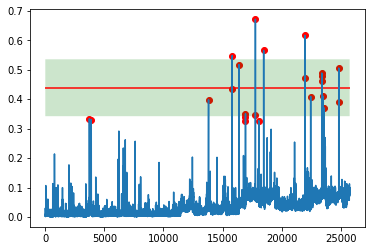

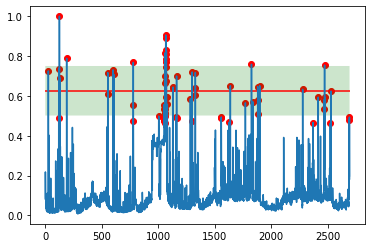

0.34247798 0.5358891
0.50167906 0.7503854
0.1804566011105173


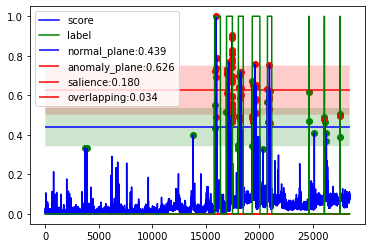

In [194]:
label = data_dict["lstm-machine-1-1"]["label"]
score = data_dict["lstm-machine-1-1"]["score"]
salience = clustering_metric(score, label, plot=True)
print(salience)

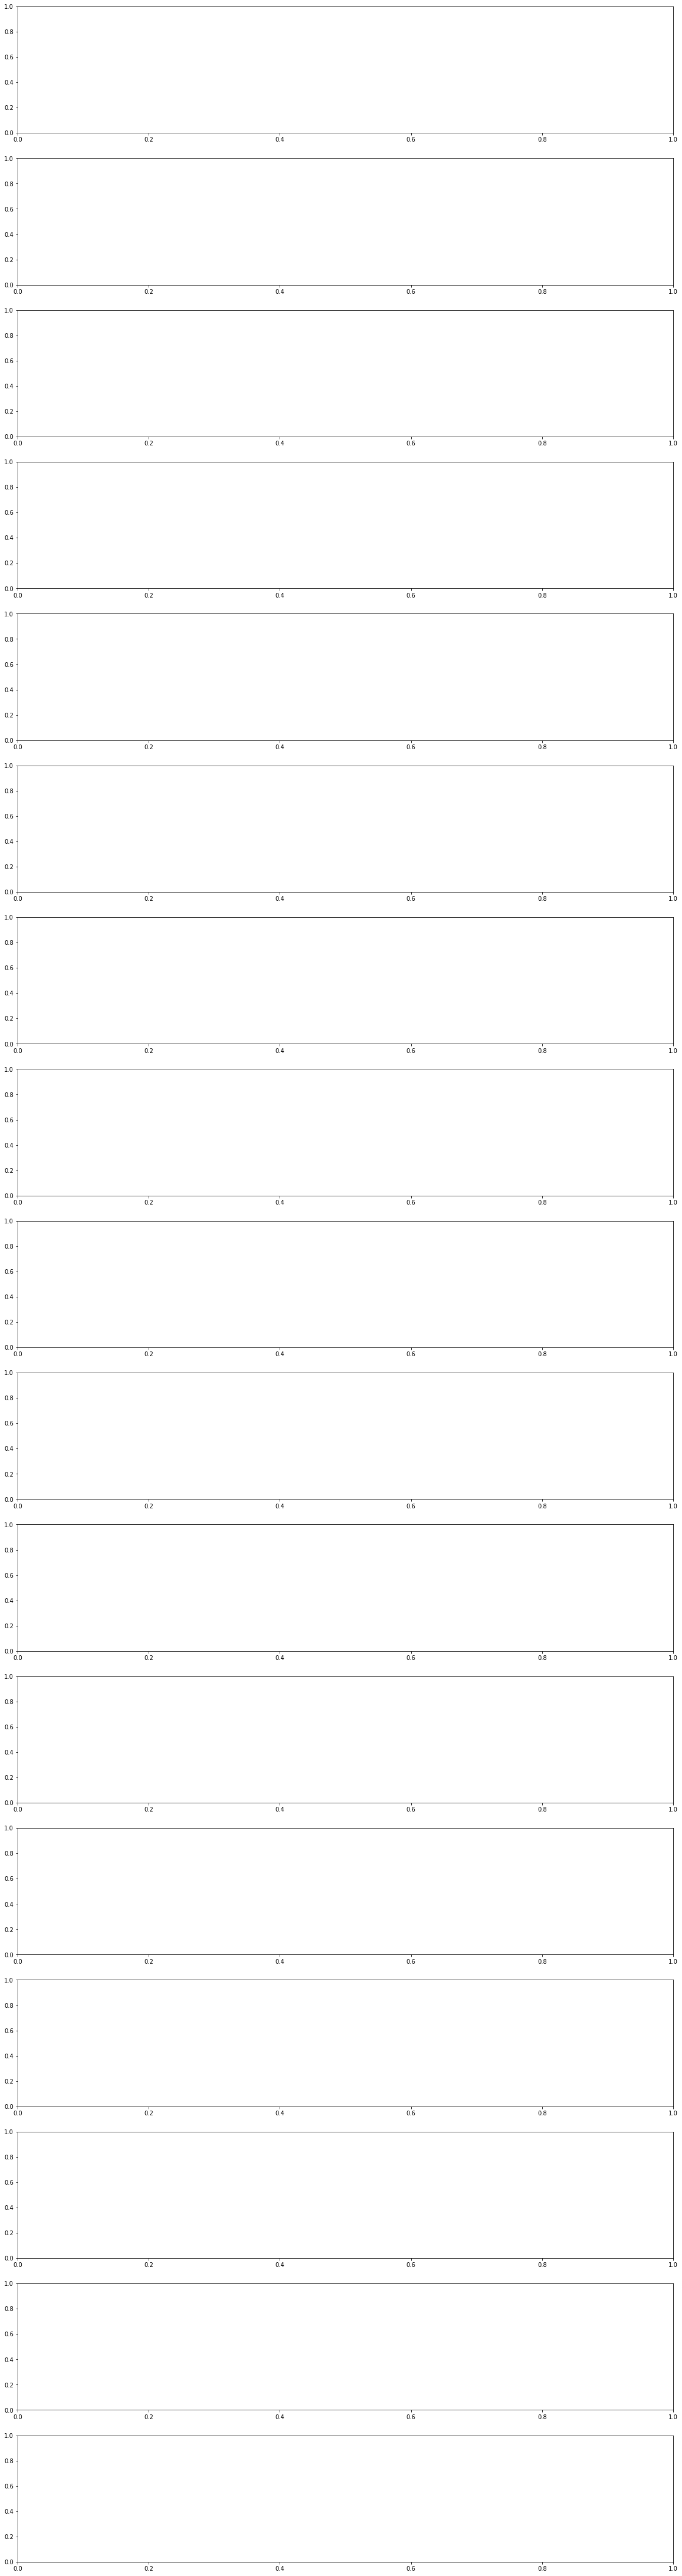

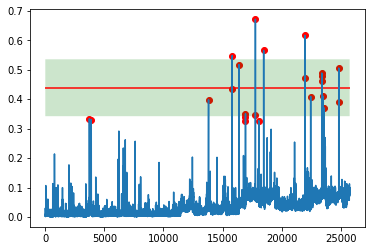

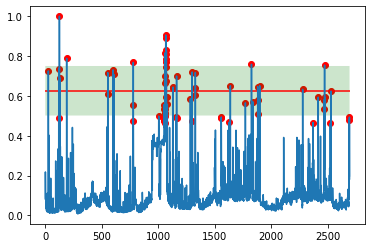

0.34247798 0.5358891
0.50167906 0.7503854


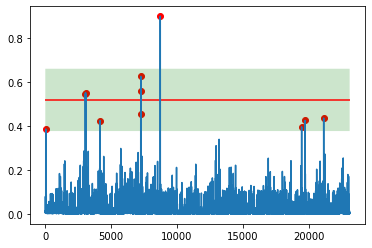

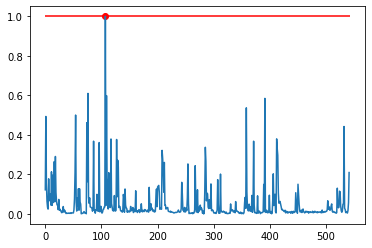

0.37677246 0.66013545
1.0 1.0


In [ ]:
fig, ax = plt.subplots(nrows=len(data_dict), sharey=False, figsize=(20,80))

items = list(data_dict.items())
for idx, (attempt, res) in enumerate(items[0:10]):
    score = res["score"]
    label = res["label"]
    
    clustering_metric(score, label, plot=True, ax=ax[idx])

#### SR

/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


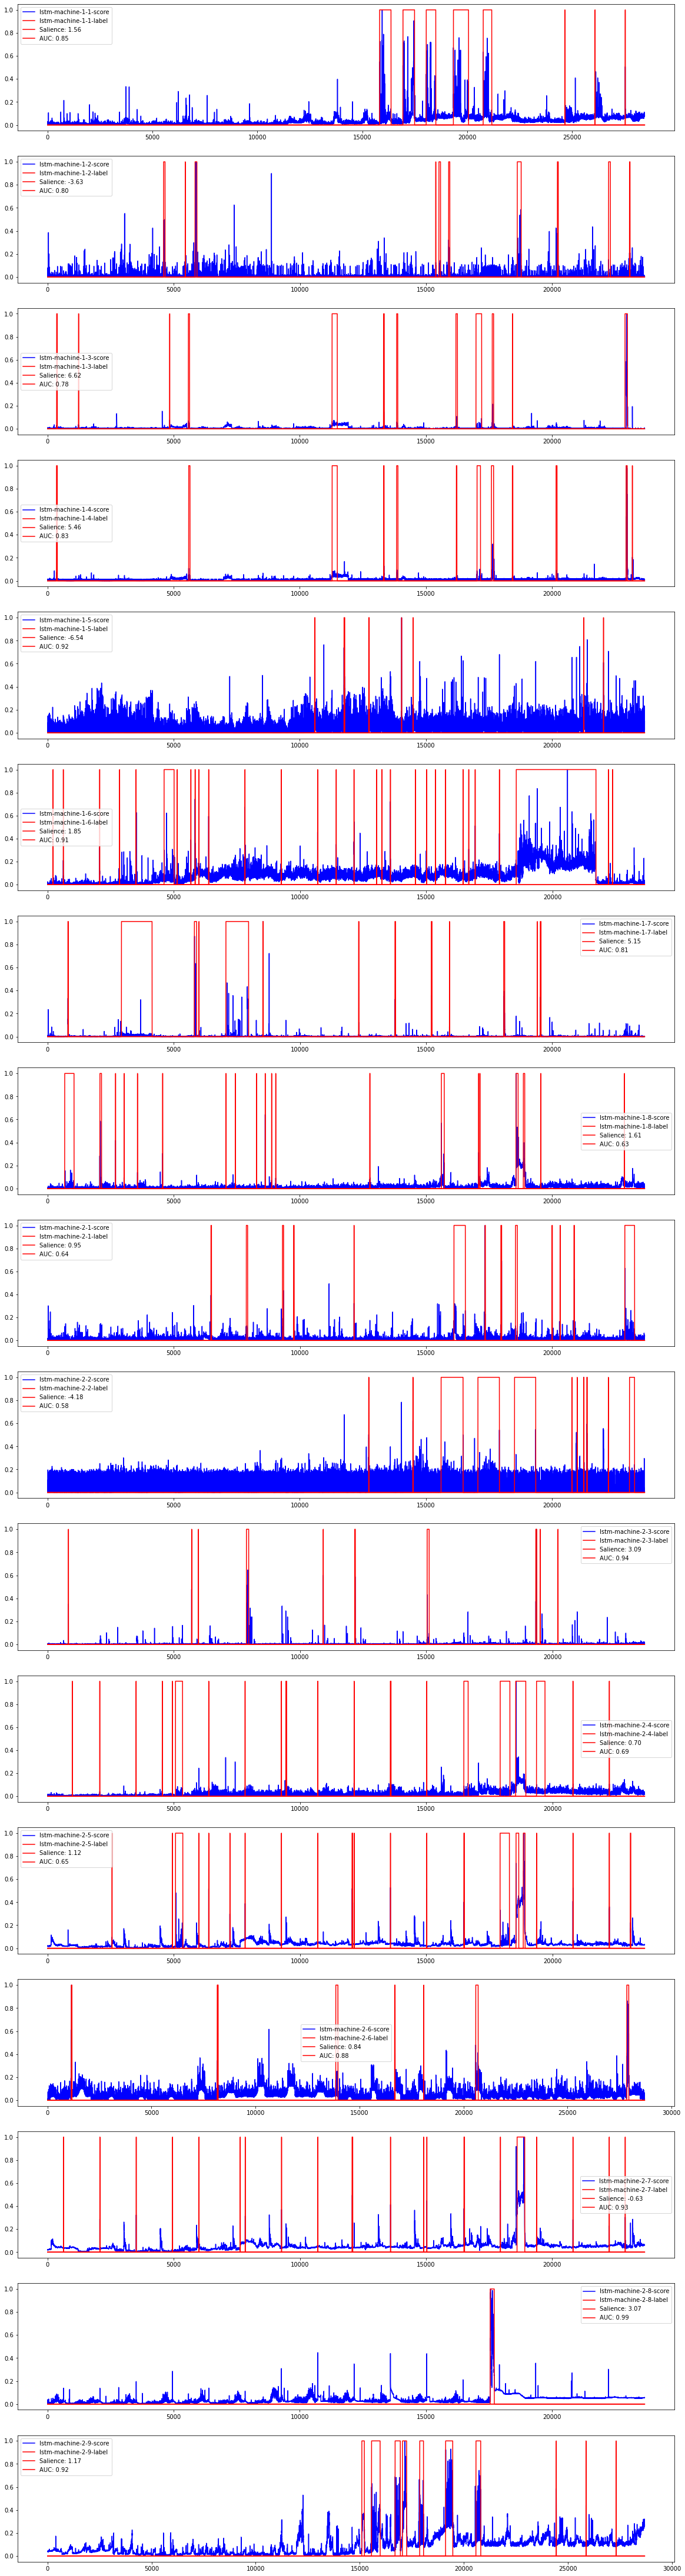

In [10]:
from alibi_detect.od import SpectralResidual

est = MinMaxScaler()

fig, ax = plt.subplots(nrows=len(data_dict), sharey=False, figsize=(20,80))

for idx, (attempt, res) in enumerate(data_dict.items()):
    score = res["score"]
    label = res["label"]

#     od = SpectralResidual(
#         threshold=None,  # threshold for outlier score
#         window_amp=100,   # window for the average log amplitude
#         window_local=100, # window for the average saliency map
#         n_est_points=20  # nb of estimated points padded to the end of the sequence
#     )
#     ax[idx].plot(od.saliency_map(score.reshape(-1)))
#     ax[idx+1].plot(score)

    
    salience = compute_emd_salience(res["score"], res["label"])
    auc = roc_auc_score(res["label"].astype(int), res["score"].reshape(-1))
    
    ax[idx].plot(score, 'b', label=f"{attempt}-score")
    ax[idx].plot(res["label"], 'r', label=f'{attempt}-label')
    ax[idx].plot(np.zeros(res["label"].shape[0]), 'r', label='Salience: {:.2f}'.format(salience))
    ax[idx].plot(np.zeros(res["label"].shape[0]), 'r', label='AUC: {:.2f}'.format(auc))
    ax[idx].legend()
#     plt.show()

# data_dict["lstm"]["score"] = est.fit_transform(data_dict["lstm"]["score"].reshape(-1,1))
# data_dict["lstm_vae"]["score"] = est.fit_transform(data_dict["lstm_vae"]["score"].reshape(-1,1))
# data_dict["dagmm"]["score"] = est.fit_transform(data_dict["dagmm"]["score"].reshape(-1,1))



# ax[1].plot(data_dict["lstm_vae"]["score"], 'b', label="lstm-score", alpha=1)
# ax[1].plot(data_dict["lstm_vae"]["label"], 'r', label='label', alpha=1)

# ax[2].plot(data_dict["dagmm"]["score"], 'b', label="dagmm-score", alpha=1)
# ax[2].plot(data_dict["dagmm"]["label"], 'r', label='label', alpha=1)
# plt.show()

-66.03784487733972


/Users/liujinyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


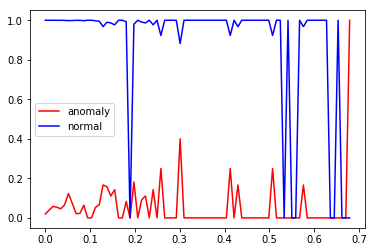

None
-45.26462520933879


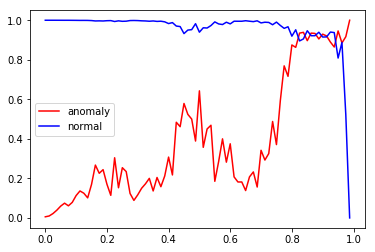

None
-31.665568435872366


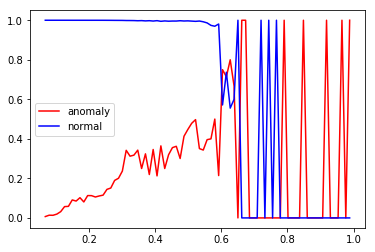

None


In [13]:
bins=80
score = data_dict["lstm"]["score"]
label = data_dict["lstm"]["label"]
lstm_emd = compute_emd_salience(score, label, bins=bins)
print(lstm_emd)

score = data_dict["lstm_vae"]["score"]
label = data_dict["lstm_vae"]["label"]
lstm_vae_emd = compute_emd_salience(score, label, bins=bins)
print(lstm_vae_emd)

score = data_dict["dagmm"]["score"]
label = data_dict["dagmm"]["label"]
dagmm_emd = compute_emd_salience(score, label, bins=bins)
print(dagmm_emd)

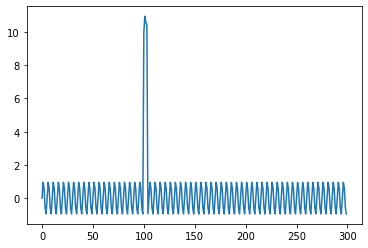

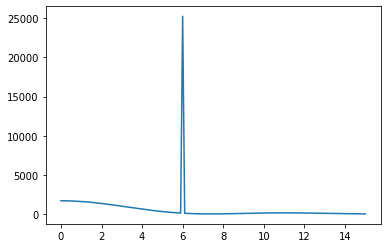

In [17]:
sampling_rate = 30.0
time = np.arange(0, 10, 1/sampling_rate)
anomaly = np.zeros(len(time))
anomaly[101] = 10
anomaly[100] = 10
anomaly[102] = 10
anomaly[103] = 11
data = np.sin(2*np.pi*6*time) + anomaly
fourier_transform = np.fft.rfft(data)
abs_fourier_transform = np.abs(fourier_transform)
power_spectrum = np.square(abs_fourier_transform)
frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
plt.figure()
plt.plot(data)
plt.figure()
plt.plot(frequency, power_spectrum)

In [ ]:
print("Normal:")
hist_n, edges_n = compute_hist(score_n, bins=edges_a, axis="y")
    
score = data_dict["lstm"]["score"].reshape(-1)

print(data_dict["lstm"]["label"].astype(int).sum())
score_a = score[data_dict["lstm"]["label"].astype(bool)]
score_n = score[~data_dict["lstm"]["label"].astype(bool)]
print(score_a.shape, score_n.shape)


plt.figure()
plt.plot(score)
plt.plot(label, "r")
plt.show()

print("Anomaly:")
hist_a, edges_a = compute_hist(score_a, bins=10, axis="y")
print(hist_a, edges_a)
plt.figure()
plt.bar(range(len(hist_a)), hist_a)


print("Normal:")
hist_n, edges_n = compute_hist(score_n, bins=edges_a, axis="y")
print(hist_n, edges_n)
plt.figure()
plt.bar(range(len(hist_n)), hist_n)

In [273]:
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss


bins=100

model = "lstm_vae"
score = data_dict[model]["score"].reshape(-1)

print(data_dict[model]["label"].astype(int).sum())
score_a = score[data_dict[model]["label"].astype(bool)]
score_n = score[~data_dict[model]["label"].astype(bool)]

print(bins)
hist_a, edges_a = compute_hist(score_a, bins=bins, axis="y")
hist_n, edges_n = compute_hist(score_n, bins=bins, axis="y")

# print("anomaly")
# print(hist_a, edges_a, len(hist_a))
# print("normal")
# print(hist_n, edges_n, len(hist_n))

print(hist_n.shape, bins)
drop = 20
hist_a = hist_a[drop:]
hist_a = hist_a / hist_a.sum()
hist_n = hist_n[drop:]
hist_n = hist_n / hist_n.sum()
bins -= (1+drop)


x = np.arange(bins, dtype=np.float64)
M = ot.dist(x.reshape((bins, 1)), x.reshape((bins, 1)))
M = M / M.max()

# from pyemd import emd
# print(emd(hist_a.astype(float), hist_n.astype(float), M))

2694
100
(99,) 100


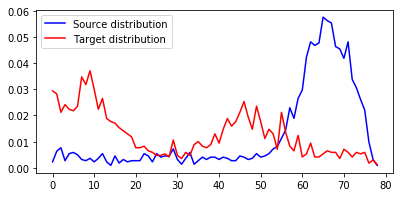

In [274]:
plt.figure(1, figsize=(6.4, 3))
plt.plot(x, hist_a, 'b', label='Source distribution')
plt.plot(x, hist_n, 'r', label='Target distribution')
plt.legend()

In [ ]:
from pyemd import emd
n = bins
mgrid = np.meshgrid(np.arange(n), np.arange(n))
metric = np.abs(mgrid[0] - mgrid[1]).astype(np.float64)
# %timeit emd(hist_a, hist_n, metric)
emd(hist_a, hist_n, metric)

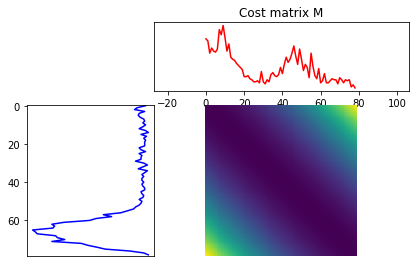

In [275]:
ot.plot.plot1D_mat(hist_a, hist_n, M, 'Cost matrix M')

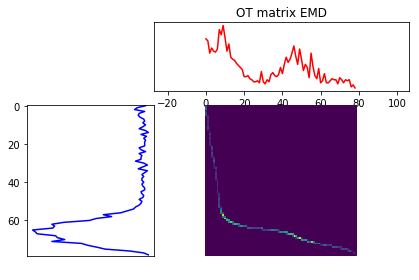

In [276]:
G0 = ot.emd(hist_a, hist_n, M)
ot.plot.plot1D_mat(hist_a, hist_n, G0, 'OT matrix EMD')
plt.show()
print()

In [278]:
ot.emd2_1d(hist_a, hist_n, hist_a, hist_n)

0.0003364054157639953

In [281]:

n = 256
window = (np.sin(np.linspace(0, 7*np.pi, n*2)) + 1) ** 4
a_off = n//2 - n//8
b_off = n//2 + n//8
a = np.copy(window[a_off:a_off+n])
b = np.copy(window[b_off:b_off+n])
a /= a.sum()
b /= b.sum()
mgrid = np.meshgrid(np.arange(n), np.arange(n))
metric = np.abs(mgrid[0] - mgrid[1]).astype(np.float64)
%timeit emd(a, b, metric)
emd(a, b, metric)

268 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


58.283378261205044

28.37035128626402

(79, 79)